In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [62]:
from gensim.models.keyedvectors import KeyedVectors
import networkx as nx

import numpy as np
import pandas as pd

from ipywidgets.widgets import HTML

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

#### Format data & get labels

In [3]:
def clean_data(eurovison_df, min_years = 5, last_participation=8):
    """
    eurovison_df: the original eurovision dataset
    min_year: minimum years of participations
    last_participation: has participated in the last x years
    """    
    #Removing duplicates
    eurovison_df['duplicate'] = eurovison_df['duplicate'].apply(lambda x: True if x == 'x' or x==True else False)
    eurovison_df = eurovison_df.query('duplicate == False').drop(columns=['duplicate'])

    
    #Stantardazing countries names.
    def rename_country(x):
        renamings ={
            'North Macedonia':'Macedonia',
            'F.Y.R. Macedonia':'Macedonia',
            'The Netherands': 'Netherlands',
            'The Netherlands':'Netherlands',
            'Bosnia & Herzegovina':'Bosnia',
        }
        return renamings[x] if x in renamings else x

    eurovison_df['countryfrom'] = eurovison_df['countryfrom'].apply(rename_country)
    eurovison_df['countryto']   = eurovison_df['countryto'].apply(rename_country)

    #replicating  Yugoslavia's results to countries that part of it.
    division = {
        'Yugoslavia':['Macedonia','Serbia','Montenegro','Slovenia','Bosnia','Croatia'],
        'Serbia & Montenegro':['Serbia','Montenegro'],
    }
    
    eurovison_df['countryfrom'] = eurovison_df['countryfrom'].apply(lambda x:division[x] if x in division else x)
    eurovison_df['countryto']   = eurovison_df['countryto'].apply(lambda x:division[x] if x in division else x)
    eurovison_df = eurovison_df.explode('countryfrom').explode('countryto')
    

    # removing countries with less then x participations and not active in the last x years
    toKeep = eurovison_df.groupby('countryfrom').apply(
        lambda x:pd.Series({
            'years':x['year'].nunique(),
            'last_participation':eurovison_df['year'].max() - x['year'].max(),
            })).query(f'years >= {min_years} and last_participation <= {last_participation}').reset_index()['countryfrom'];
    
    display(HTML("<p>ignored countries: %s</p>" %', '.join(eurovison_df[eurovison_df['countryfrom'].isin(toKeep)==False]['countryfrom'].unique())))

    eurovison_df = eurovison_df[eurovison_df['countryfrom'].isin(toKeep)]
    eurovison_df = eurovison_df[eurovison_df['countryto'].isin(toKeep)]
    
    return eurovison_df.reindex()


In [4]:
eurovision_votes = pd.read_csv('./gdrive/MyDrive/eurovision-project/final_data/eurovision_votes_1975_2021.csv')
eurovision_votes.columns = ['year','final','edition','votetype','countryfrom','countryto','points','duplicate']
eurovision_votes = clean_data(eurovision_votes)

HTML(value='<p>ignored countries: Luxembourg, Monaco, Turkey, Morocco, Slovakia, Andorra</p>')

#### Ranking Approach

In [5]:
voting_type_to_years = {'J': [2015, 2016, 2017, 2018],
                        'T': [2016, 2017, 2018]  ## televoting began in 2016
                        }
relation_types = ['trade', 'tour']

In [6]:
ranking_replace_dict = {1:12,
                        2:10,
                        3:8,
                        4:7,
                        5:6,
                        6:5,
                        7:4,
                        8:3,
                        9:2,
                        10:1}
ranking_replace_dict.update({i: 0 for i in range(11, 28)})

In [9]:
shift = True

In [7]:
def get_eurovision_voting_matrix(year, voting_type):
  final_countries = eurovision_votes[(eurovision_votes['year'] == int(year)) &
                                    (eurovision_votes['final'] == 'f')]['countryto'].unique()
  eurovision_votes_mat = pd.pivot_table(eurovision_votes[(eurovision_votes['year'] == int(year)) &
                                                       (eurovision_votes['final'] == 'f') &
                                                       (eurovision_votes['votetype'] == voting_type)],
                                      index='countryfrom',
                                      columns='countryto',
                                      values='points',
                                      aggfunc='sum')[final_countries].fillna(0)
  eurovision_votes_mat.sort_index(inplace=True)
  return eurovision_votes_mat


def get_relation_type_mat(relation_type, year):
  graph_year = year - 1 if shift else year
  graph_path = (f'./gdrive/MyDrive/eurovision-project/graphs/euro_{relation_type}_graph_all{graph_year}.gpickle' if relation_type == 'trade' 
                else f'./gdrive/MyDrive/eurovision-project/graphs/{relation_type}_graph_no_norm_{graph_year}.gpickle')
  G = nx.read_gpickle(graph_path)
  mat = nx.linalg.graphmatrix.adjacency_matrix(G, weight='Share' if relation_type == 'trade' else 'weight')
  mat = mat.toarray()
  countries_order = list(G.nodes)
  relation_type_df = pd.DataFrame(mat, index=countries_order, columns=countries_order)
  relation_type_df.sort_index(inplace=True)
  return relation_type_df


def intersect_countries(eurovision_votes_mat, relation_type_mat):
  mutual_column_countries = eurovision_votes_mat.columns.intersection(relation_type_mat.columns).values
  relation_type_mat = relation_type_mat[mutual_column_countries]
  eurovision_votes_mat = eurovision_votes_mat[mutual_column_countries]

  mutual_index_countries = eurovision_votes_mat.index.intersection(relation_type_mat.index).values
  relation_type_mat = relation_type_mat.loc[mutual_index_countries]
  eurovision_votes_mat = eurovision_votes_mat.loc[mutual_index_countries]

  assert (eurovision_votes_mat.columns == relation_type_mat.columns).all()
  assert (eurovision_votes_mat.index == relation_type_mat.index).all()
  return eurovision_votes_mat, relation_type_mat



In [52]:
results = []

for relation_type in relation_types:
  for voting_type, years in voting_type_to_years.items():
    for year in years:
      eurovision_votes_mat = get_eurovision_voting_matrix(year, voting_type)
      relation_type_mat = get_relation_type_mat(relation_type, year)
      eurovision_votes_mat, relation_type_mat = intersect_countries(eurovision_votes_mat, relation_type_mat)

      relation_type_mat = relation_type_mat.rank(axis=1, ascending=False, method='min')
      relation_type_mat = relation_type_mat.replace(ranking_replace_dict)
      result = spearmanr(relation_type_mat.values, eurovision_votes_mat.values, axis=None)

      results.append({'relation_type': relation_type,
                      'voting_type': voting_type,
                      'year': year,
                      'corr': result.correlation,
                      'pval': result.pvalue})



Format results for plotting purposes

In [53]:
results_df = pd.DataFrame(results)
results_df.replace({'tour': 'tourism'}, inplace=True)
results_df['voting_type'] = results_df['voting_type'].apply(lambda s: 'Jury' if s =='J' else 'Televoting')
results_df['corrected_pval'] = results_df['pval'].apply(lambda p: min(p* results_df.shape[0], 1)) 
results_df['significant'] = results_df['corrected_pval'] <= 0.05

In [54]:
results_df['name'] = (results_df['relation_type'].str.title() + '-' + results_df['voting_type'] + ', ' + results_df['year'].astype(str))
results_df['name'] = results_df[['name', 'significant']].apply(lambda t: t[0] + ' *' if t[1] else t[0],
                                                                             axis=1)

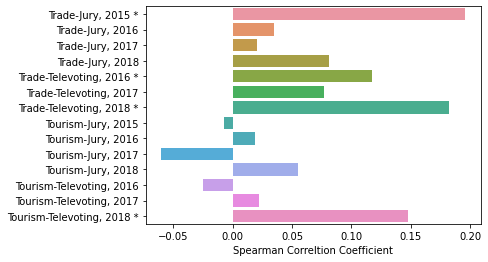

In [55]:
sns.barplot(data=results_df, x='corr', y='name', orient='h')
plt.xlabel('Spearman Correltion Coefficient')
plt.ylabel('')
plt.show()

#### Correlation Matrices

In [110]:
eurovision_2018_tele = get_eurovision_voting_matrix(2018, 'T')
eurovision_2018_jury = get_eurovision_voting_matrix(2018, 'J')

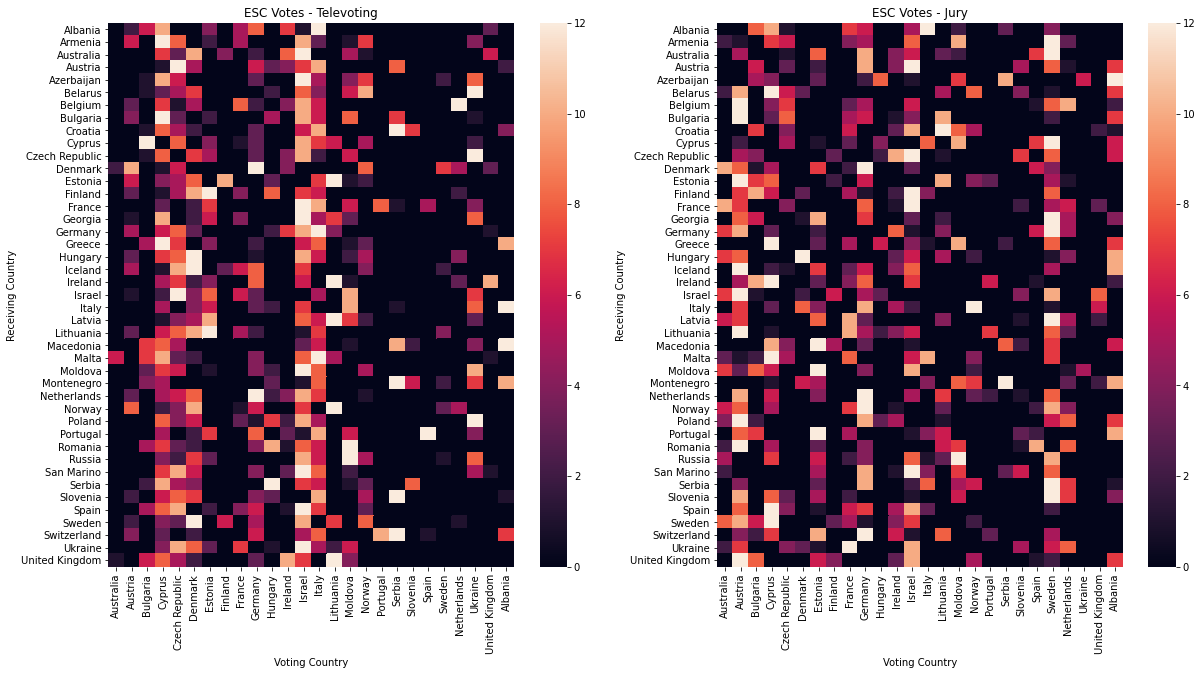

In [111]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('ESC Votes - Televoting')
# plt.figure(figsize=(10,10))
sns.heatmap(eurovision_2018_tele)
plt.xlabel('Voting Country')
plt.ylabel('Receiving Country')

plt.subplot(1,2,2)
plt.title('ESC Votes - Jury')
# plt.figure(figsize=(10,10))
sns.heatmap(eurovision_2018_jury)
plt.xlabel('Voting Country')
plt.ylabel('Receiving Country')
plt.show()

In [112]:
relation_type = 'tour'
year = 2018
voting_type = 'T'

eurovision_votes_mat = get_eurovision_voting_matrix(year, voting_type)
relation_type_mat = get_relation_type_mat(relation_type, year)
eurovision_votes_mat, relation_type_mat = intersect_countries(eurovision_votes_mat, relation_type_mat)

relation_type_mat = relation_type_mat.rank(axis=1, ascending=False, method='min')
relation_type_mat = relation_type_mat.replace(ranking_replace_dict)

In [114]:
# relation_type_mat.loc['San Marino', :] = 0
relation_type_mat.loc[['Australia', 'Macedonia', 'Russia', 'Serbia', 'Ukraine', 'United Kingdom'], :] = 0

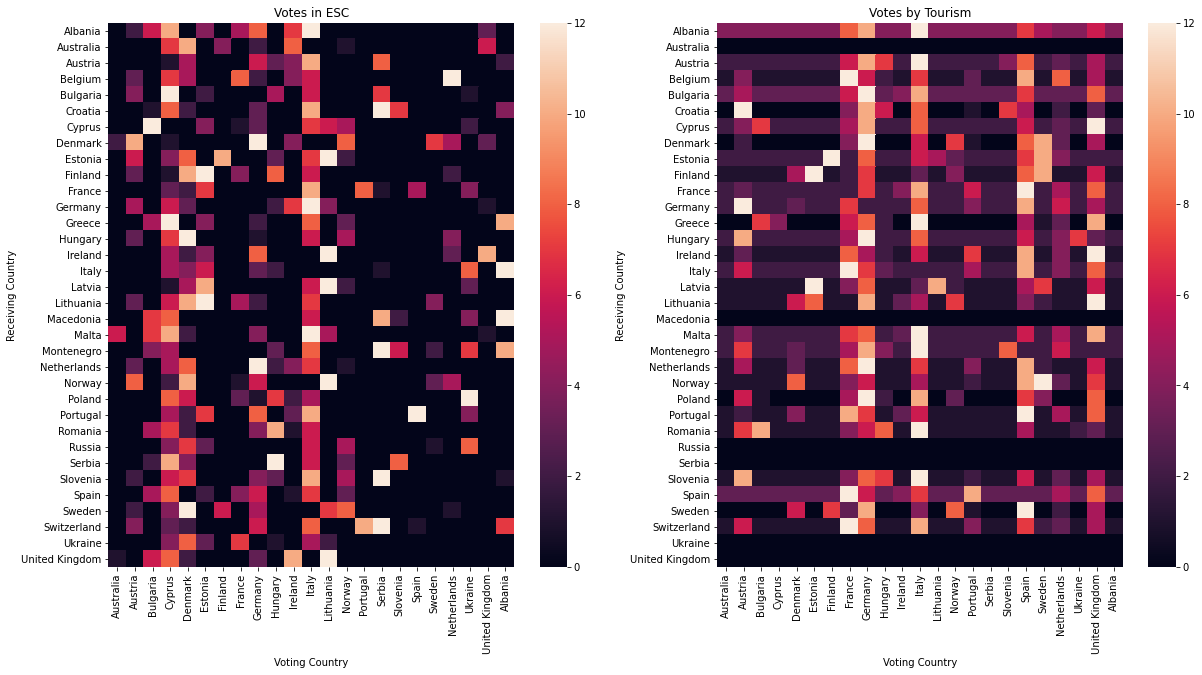

In [115]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Votes in ESC')
# plt.figure(figsize=(10,10))
sns.heatmap(eurovision_votes_mat)
plt.xlabel('Voting Country')
plt.ylabel('Receiving Country')

plt.subplot(1,2,2)
plt.title('Votes by Tourism')
# plt.figure(figsize=(10,10))
sns.heatmap(relation_type_mat)
plt.xlabel('Voting Country')
plt.ylabel('Receiving Country')
plt.show()